In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler

from sklearn.pipeline import make_pipeline
from sklearn.base import clone

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, chi2, SelectPercentile, f_classif
from sklearn.model_selection import train_test_split, cross_val_score, KFold

from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA, NMF

from mlens.visualization import pca_plot, pca_comp_plot
from matplotlib import pyplot as plt

def get_models():
    nb = GaussianNB()
    svc = SVC(kernel='rbf', C=100, gamma=1e-3, probability=True, class_weight='balanced')
    knn = KNeighborsClassifier(n_neighbors=8)
    lr = LogisticRegression(C=100, random_state=seed)
    nn = MLPClassifier((16, 8), solver='lbfgs', activation='relu', random_state=seed)
    gb = GradientBoostingClassifier(n_estimators=32, random_state=seed)
    rf = RandomForestClassifier(n_estimators=8, max_features=2, random_state=seed)
    ab = AdaBoostClassifier(random_state=seed)
    
    models = {'svm': svc, 'knn': knn, 'naive bayes': nb,
             'mlp': nn, 'random forest': rf, 'gradientboost': gb, 'logistic': lr,
             'adaboost': ab}
    return models

def get_sex(PatientSex):
    return 1 if PatientSex is 'M' else 0

def get_sample_weight(y):
    y = y.astype('int')
    class_weight = len(y) / (2 * np.bincount(y))
    sample_weight = (np.ones_like(y) * y * class_weight[1]) + (np.ones_like(y) * (1 - y) * class_weight[0] * 0.78)
    return sample_weight
        

def train_predict(model_list):
    P = np.zeros((y_test.shape[0], len(model_list)))
    P = pd.DataFrame(P)
    
    print('Fitting models...')
    cols = list()
    for i, (name, m) in enumerate(model_list.items()):
        print("%s..." % name, end=" ", flush=False)
        try:
            m.fit(x_train, y_train, sample_weight=get_sample_weight(y_train))
        except:
            print('no sample weight')
            m.fit(x_train, y_train)
        try:
            print('\n', name, m.feature_importances_)
        except:
            print('no feature importances')
        P.iloc[:, i] = m.predict_proba(x_test)[:, 1]
        cols.append(name)
        print("done")
    
    P.columns = cols
    print("Done.\n")
    return P

def cross_val_models(model_list, cv=5, scoring='accuracy'):
    P = np.zeros((cv, len(model_list)))
    P = pd.DataFrame(P)

    print('Fitting models...')
    cols = list()
    for i, (name, m) in enumerate(model_list.items()):
        print("%s..." % name, end=" ", flush=False)
        P.iloc[:, i] = cross_val_score(m, X, y, cv=cv, scoring=scoring)
        cols.append(name)
        print("done")
    P.columns = cols
    print('Done.\n')
    return P

def cross_val_acc(P, scoring='ACC'):
    for m in P.columns:
        score = np.mean(P.loc[:, m])
        std = 2 * np.std(P.loc[:, m])
        print('{} {} Result {} +/- {}'.format(m, scoring, score, std))

def score_models(P, y):
    print('ROC AUC SCORE')
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        print("%-26s: %.3f" % (m, score))
    print('ACC SCORE')
    for m in P.columns:
        score = accuracy_score(y, np.float32(P.loc[:, m]>=0.5))
        print("%-26s: %.3f" % (m, score))

def plot_roc_curve(y_test, P_base_learners, P_ensemble, labels, ens_label):
    plt.plot([0, 1], [0, 1], 'k--')
    #cm = [plt.cm.gray(i) for i in np.linspace(0, 1.0, P_base_learners.shape[1])]
    cm = sns.color_palette("Blues", P_base_learners.shape[1])
    
    for i in range(P_base_learners.shape[1]):
        p = P_base_learners[:, i]
        fpr, tpr, _ = roc_curve(y_test, p)
        plt.plot(fpr, tpr, label=labels[i], c=cm[i])
        
    fpr, tpr, _ = roc_curve(y_test, P_ensemble)
    plt.plot(fpr, tpr, label=ens_label, c='red')
    
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend()
    plt.show()
    
def train_base_learners(base_learners, x_train, y_train):
    print('Fitting models')
    for i, (name, m) in enumerate(base_learners.items()):
        print('%s...'% name, end='', flush=False)
        try:
            m.fit(x_train, y_train, sample_weight=get_sample_weight(y_train))
        except:
            m.fit(x_train, y_train)
            print('no sample_weight')
    print('done.')

def predict_base_learners(base_learners, x):
    P = np.zeros((x.shape[0], len(base_learners)))
    print('Generating base learner predictions.')
    for i, (name, m) in enumerate(base_learners.items()):
        print('%s...'% name, end='', flush=False)
        p = m.predict_proba(x)
        P[:, i] = p[:, 1]
    print('done.')
    return P

def ensemble_predict(base_learners, meta_learner, x):
    P_pred = predict_base_learners(base_learners, x)
    return P_pred, meta_learner.predict_proba(P_pred)[:, 1]

[MLENS] backend: threading


In [2]:
raw_data = pd.read_csv('analysisAll.csv', index_col=0)

In [3]:
raw_data.columns

Index(['Age', 'InstitutionName', 'Manufacturer', 'PatientBirthDate',
       'PatientID', 'PatientSex', 'Severe', 'StudyDate', 'StudyID',
       'StudyTime', 'check', 'consolidation', 'filename', 'left_lesion',
       'left_lung', 'lesion', 'lesion_consolidation', 'lung', 'lung_lesion',
       'patientID', 'ratio', 'right_lesion', 'right_lung', 'severe', 'shape',
       'slice', 'spacing', 'studyDate', 'weighted_lesion',
       'weighted_lung_lesion', 'z'],
      dtype='object')

In [4]:
feature = ['lung', 'lesion', 'ratio', 'lung_lesion', 
           #'left_lung', 'right_lung', 'left_lesion', 'right_lesion',
          'weighted_lesion', 'weighted_lung_lesion',
          'consolidation', 'lesion_consolidation',
          'z', 'Age', 'sex']

In [5]:
raw_data['sex'] = raw_data['PatientSex'].map(get_sex)
cls_data = raw_data
cls_data.loc[cls_data['Severe'] == 2, 'Severe'] = 1

In [6]:
X = np.array(cls_data[feature]).astype(np.float32)

In [7]:
y = np.array(cls_data['Severe'])

In [8]:
y

array([0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,

In [9]:
seed = 2
np.random.seed(seed)

In [10]:
print(X.shape)

(434, 11)


In [11]:
X = MinMaxScaler().fit_transform(X)
#selector = VarianceThreshold(0.01)
#selector.fit(X)
#X = selector.transform(X)
print(X.shape)
#etc = GradientBoostingClassifier().fit(X, y)
#model = SelectFromModel(etc, prefit=True)
#X = model.transform(X)
print(X.shape)

(434, 11)
(434, 11)


In [12]:
feature

['lung',
 'lesion',
 'ratio',
 'lung_lesion',
 'weighted_lesion',
 'weighted_lung_lesion',
 'consolidation',
 'lesion_consolidation',
 'z',
 'Age',
 'sex']

C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\extmath.py:516: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


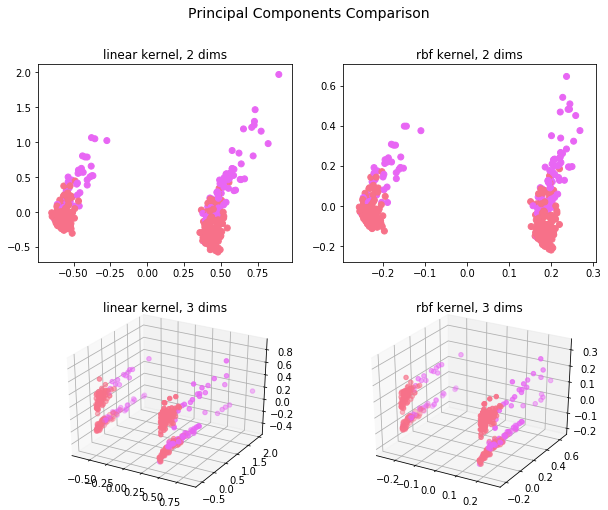

In [13]:
pca_comp_plot(X, y)

In [14]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
print('样本集大小：',X.shape,y.shape)
print('训练集大小：',x_train.shape,y_train.shape)  # 训练集样本大小
print('测试集大小：',x_test.shape,y_test.shape)  # 测试集样本大小

样本集大小： (434, 11) (434,)
训练集大小： (347, 11) (347,)
测试集大小： (87, 11) (87,)


In [15]:
models = get_models()
P = train_predict(models)
score_models(P, y_test)

Fitting models...
svm... no feature importances
done
knn... no sample weight
no feature importances
done
naive bayes... no feature importances
done
mlp... no sample weight
no feature importances
done
random forest... 
 random forest [0.06556802 0.06267865 0.10769074 0.23554236 0.0675672  0.11787239
 0.06881165 0.15614353 0.04052227 0.06618391 0.01141929]
done
gradientboost... 
 gradientboost [0.02102846 0.28094372 0.08241749 0.04754522 0.05069486 0.02973711
 0.23328546 0.20862373 0.02436599 0.02135795 0.        ]
done
logistic... no feature importances
done
adaboost... 
 adaboost [0.08 0.06 0.1  0.12 0.16 0.04 0.18 0.08 0.08 0.1  0.  ]
done
Done.

ROC AUC SCORE
svm                       : 0.893
knn                       : 0.905
naive bayes               : 0.897
mlp                       : 0.908
random forest             : 0.862
gradientboost             : 0.909
logistic                  : 0.899
adaboost                  : 0.848
ACC SCORE
svm                       : 0.828
knn           

C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [16]:
models = get_models()
cv_results=cross_val_models(models)
cross_val_acc(cv_results)

Fitting models...
svm... done
knn... done
naive bayes... done
mlp... done
random forest... done
gradientboost... done
logistic... 

C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logisti

done
adaboost... done
Done.

svm ACC Result 0.8237315010570825 +/- 0.3017880613142109
knn ACC Result 0.7478858350951375 +/- 0.2920472229603193
naive bayes ACC Result 0.8306025369978858 +/- 0.26769702623988184
mlp ACC Result 0.7806025369978858 +/- 0.3575818547409162
random forest ACC Result 0.775475687103594 +/- 0.28610783615005586
gradientboost ACC Result 0.7620507399577168 +/- 0.3986433824327496
logistic ACC Result 0.8097251585623679 +/- 0.2858060473499701
adaboost ACC Result 0.7620507399577167 +/- 0.35577830735987864


In [17]:
cv_results

,svm,knn,naive bayes,mlp,random forest,gradientboost,logistic,adaboost
0,0.534091,0.477273,0.579545,0.477273,0.522727,0.386364,0.534091,0.443182
1,0.863636,0.727273,0.840909,0.693182,0.750000,0.772727,0.875000,0.715909
2,0.930233,0.883721,0.895349,0.860465,0.848837,0.837209,0.895349,0.918605
3,0.837209,0.790698,0.860465,0.883721,0.802326,0.837209,0.813953,0.802326
4,0.953488,0.860465,0.976744,0.988372,0.953488,0.976744,0.930233,0.930233


In [18]:
cv_results_roc=cross_val_models(models, scoring='roc_auc')
cross_val_acc(cv_results_roc, scoring='ROC AUC')

Fitting models...
svm... done
knn... done
naive bayes... done
mlp... done
random forest... done
gradientboost... done
logistic... done
adaboost... 

C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logisti

done
Done.

svm ROC AUC Result 0.8927574611181168 +/- 0.27380216453532236
knn ROC AUC Result 0.8555520526832001 +/- 0.3006267128541013
naive bayes ROC AUC Result 0.8604128718882815 +/- 0.29500499579004863
mlp ROC AUC Result 0.8602090047172014 +/- 0.3352491413984705
random forest ROC AUC Result 0.8340632151697726 +/- 0.2669250384669379
gradientboost ROC AUC Result 0.856611554808276 +/- 0.34781065652988397
logistic ROC AUC Result 0.8978590444164215 +/- 0.2869042332673911
adaboost ROC AUC Result 0.8341810284433235 +/- 0.2870453702783311


In [19]:
print("Ensemble ROC-AUC score: %.3f" % roc_auc_score(y_test, P.mean(axis=1)))
print("Ensemble ACC score: %.3f" % accuracy_score(y_test, np.float32(P.mean(axis=1) > 0.5)))

Ensemble ROC-AUC score: 0.936
Ensemble ACC score: 0.885


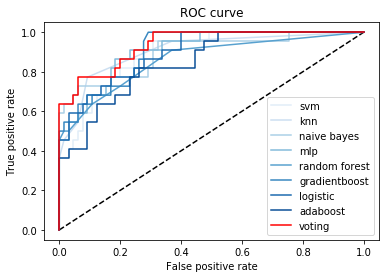

In [20]:
plot_roc_curve(y_test, P.values, P.mean(axis=1), list(P.columns), 'voting')

In [21]:
base_learners = get_models()

In [22]:
meta_learner = GradientBoostingClassifier(
   n_estimators=128,
   loss="exponential",
   max_features=4,
   max_depth=3,
   subsample=0.5,
   learning_rate=0.005, 
   random_state=seed
)

In [23]:
train_base_learners(base_learners, x_train, y_train)

Fitting models
svm...knn...no sample_weight
naive bayes...mlp...no sample_weight
random forest...gradientboost...logistic...adaboost...done.


C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [24]:
P_base = predict_base_learners(base_learners, x_train)
P_test = predict_base_learners(base_learners, x_test)

Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradientboost...logistic...adaboost...done.
Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradientboost...logistic...adaboost...done.


In [25]:
meta_learner.fit(P_base, y_train, sample_weight=get_sample_weight(y_train))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.005, loss='exponential', max_depth=3,
                           max_features=4, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=128,
                           n_iter_no_change=None, presort='auto',
                           random_state=2, subsample=0.5, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [26]:
P_pred, p = ensemble_predict(base_learners, meta_learner, x_test)
print("\nEnsemble ROC-AUC score: %.3f" % roc_auc_score(y_test, p))
print("Ensemble ACC score: %.3f" % accuracy_score(y_test, np.float32(p > 0.5)))

Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradientboost...logistic...adaboost...done.

Ensemble ROC-AUC score: 0.838
Ensemble ACC score: 0.828


In [27]:
c = 0
for k, v in base_learners.items():
    print("{} ROC-AUC score: %.3f".format(k) % roc_auc_score(y_test, P_pred[:, c]))
    print("{} ACC score: %.3f \n".format(k) % accuracy_score(y_test, np.float32(P_pred[:, c] > 0.5)))
    c = c + 1

svm ROC-AUC score: 0.893
svm ACC score: 0.816 

knn ROC-AUC score: 0.905
knn ACC score: 0.851 

naive bayes ROC-AUC score: 0.897
naive bayes ACC score: 0.885 

mlp ROC-AUC score: 0.908
mlp ACC score: 0.839 

random forest ROC-AUC score: 0.862
random forest ACC score: 0.862 

gradientboost ROC-AUC score: 0.909
gradientboost ACC score: 0.793 

logistic ROC-AUC score: 0.899
logistic ACC score: 0.851 

adaboost ROC-AUC score: 0.848
adaboost ACC score: 0.816 



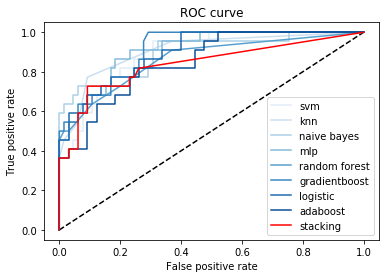

In [28]:
plot_roc_curve(y_test, P.values, p, list(P.columns), 'stacking')

In [29]:
idx = list(range(len(X)))
np.random.shuffle(idx)
X = X[idx]
y = y[idx]
cv_scores = []
for i, (train_idx, test_idx) in enumerate(KFold(5).split(X)):
    fold_x_train, fold_y_train = X[train_idx, :], y[train_idx]
    fold_x_test, fold_y_test = X[test_idx, :], y[test_idx]
    
    base_learners = get_models()
    meta_learner = GradientBoostingClassifier(
       n_estimators=128,
       loss="exponential",
       max_features=4,
       max_depth=3,
       subsample=0.5,
       learning_rate=0.005, 
       random_state=seed
    )
    train_base_learners(base_learners, fold_x_train, fold_y_train)
    P_base = predict_base_learners(base_learners, fold_x_train)
    P_test = predict_base_learners(base_learners, fold_x_test)
    
    meta_learner.fit(P_base, fold_y_train, sample_weight=get_sample_weight(fold_y_train))
    P_pred, p = ensemble_predict(base_learners, meta_learner, fold_x_test)

    acc = accuracy_score(fold_y_test, np.float32(p > 0.5))
    recall = recall_score(fold_y_test, np.float32(p > 0.5))
    cm = confusion_matrix(fold_y_test, np.float32(p > 0.5))
    roc = roc_auc_score(fold_y_test, p)
    print("\nEnsemble ROC-AUC score: %.3f" % roc)
    print("Ensemble ACC score: %.3f" % acc)
    
    cv_scores.append({'acc': acc, 'recall': recall, 'confusion_matrix': cm, 'roc_auc_score': roc})

Fitting models
svm...knn...no sample_weight
naive bayes...mlp...no sample_weight
random forest...gradientboost...logistic...

C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


adaboost...done.
Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradientboost...logistic...adaboost...done.
Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradientboost...logistic...adaboost...done.
Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradientboost...logistic...adaboost...done.

Ensemble ROC-AUC score: 0.876
Ensemble ACC score: 0.851
Fitting models
svm...knn...no sample_weight
naive bayes...mlp...no sample_weight
random forest...gradientboost...logistic...adaboost...done.
Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradientboost...logistic...adaboost...done.
Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradientboost...logistic...adaboost...done.


C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradientboost...logistic...adaboost...done.

Ensemble ROC-AUC score: 0.955
Ensemble ACC score: 0.908
Fitting models
svm...knn...no sample_weight
naive bayes...mlp...no sample_weight
random forest...gradientboost...logistic...adaboost...done.
Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradientboost...logistic...adaboost...done.
Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradientboost...logistic...adaboost...done.


C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradientboost...logistic...adaboost...done.

Ensemble ROC-AUC score: 0.890
Ensemble ACC score: 0.828
Fitting models
svm...knn...no sample_weight
naive bayes...mlp...no sample_weight
random forest...gradientboost...logistic...adaboost...done.
Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradientboost...logistic...adaboost...done.
Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradientboost...logistic...adaboost...done.


C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradientboost...logistic...adaboost...done.

Ensemble ROC-AUC score: 0.887
Ensemble ACC score: 0.908
Fitting models
svm...knn...no sample_weight
naive bayes...mlp...no sample_weight
random forest...gradientboost...logistic...adaboost...done.
Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradientboost...logistic...adaboost...done.
Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradientboost...logistic...adaboost...done.


C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradientboost...logistic...adaboost...done.

Ensemble ROC-AUC score: 0.836
Ensemble ACC score: 0.837


In [30]:
pd.DataFrame(cv_scores)

,acc,recall,confusion_matrix,roc_auc_score
0,0.850575,0.794118,"[[47, 6], [7, 27]]",0.875971
1,0.908046,0.720000,"[[61, 1], [7, 18]]",0.955484
2,0.827586,0.772727,"[[55, 10], [5, 17]]",0.889860
3,0.908046,0.761905,"[[63, 3], [5, 16]]",0.886724
4,0.837209,0.733333,"[[50, 6], [8, 22]]",0.836310


In [31]:
np.sum(pd.DataFrame(cv_scores)['confusion_matrix'])

array([[276,  26],
       [ 32, 100]], dtype=int64)

Text(0.5,1,'Stacking: Confusion Matrix')

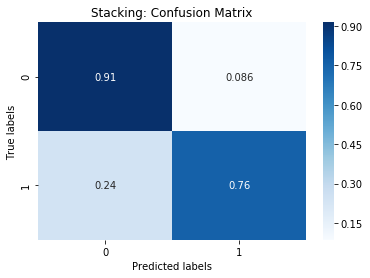

In [32]:
cm = np.sum(pd.DataFrame(cv_scores)['confusion_matrix'])
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, cmap='Blues', annot=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Stacking: Confusion Matrix')

In [33]:
cv_results['stacking'] = pd.DataFrame(cv_scores)['acc']

In [34]:
idx = list(range(len(X)))
np.random.shuffle(idx)
X = X[idx]
y = y[idx]
cv_scores_vote = []
for i, (train_idx, test_idx) in enumerate(KFold(5).split(X)):
    fold_x_train, fold_y_train = X[train_idx, :], y[train_idx]
    fold_x_test, fold_y_test = X[test_idx, :], y[test_idx]
    
    base_learners = get_models()
    meta_learner = GradientBoostingClassifier(
       n_estimators=128,
       loss="exponential",
       max_features=4,
       max_depth=3,
       subsample=0.5,
       learning_rate=0.005, 
       random_state=seed
    )
    train_base_learners(base_learners, fold_x_train, fold_y_train)
    P_test = predict_base_learners(base_learners, fold_x_test)
    p_vote = P_test.mean(axis=1)
    acc = accuracy_score(fold_y_test, np.float32(p_vote > 0.5))
    recall = recall_score(fold_y_test, np.float32(p_vote > 0.5))
    cm = confusion_matrix(fold_y_test, np.float32(p_vote > 0.5))
    roc = roc_auc_score(fold_y_test, p_vote)
    print("\nEnsemble ROC-AUC score: %.3f" % roc)
    print("Ensemble ACC score: %.3f" % acc)
    
    cv_scores_vote.append({'acc': acc, 'recall': recall, 'confusion_matrix': cm, 'roc_auc_score': roc})

Fitting models
svm...knn...no sample_weight
naive bayes...mlp...no sample_weight
random forest...gradientboost...logistic...adaboost...done.
Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradientboost...logistic...adaboost...done.

Ensemble ROC-AUC score: 0.956
Ensemble ACC score: 0.851
Fitting models
svm...knn...no sample_weight
naive bayes...mlp...

C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


no sample_weight
random forest...gradientboost...logistic...adaboost...done.
Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradientboost...logistic...adaboost...done.

Ensemble ROC-AUC score: 0.901
Ensemble ACC score: 0.816
Fitting models
svm...knn...no sample_weight
naive bayes...mlp...

C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


no sample_weight
random forest...gradientboost...logistic...adaboost...done.
Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradientboost...logistic...adaboost...done.

Ensemble ROC-AUC score: 0.971
Ensemble ACC score: 0.839
Fitting models
svm...knn...

C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


no sample_weight
naive bayes...mlp...no sample_weight
random forest...gradientboost...logistic...adaboost...

C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


done.
Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradientboost...logistic...adaboost...done.

Ensemble ROC-AUC score: 0.904
Ensemble ACC score: 0.816
Fitting models
svm...knn...no sample_weight
naive bayes...mlp...no sample_weight
random forest...gradientboost...logistic...adaboost...done.
Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradientboost...logistic...adaboost...done.

Ensemble ROC-AUC score: 0.932
Ensemble ACC score: 0.860


C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [35]:
cv_results['voting'] = pd.DataFrame(cv_scores_vote)['acc']

In [36]:
pd.DataFrame(cv_scores_vote)

,acc,recall,confusion_matrix,roc_auc_score
0,0.850575,0.666667,"[[58, 5], [8, 16]]",0.956349
1,0.816092,0.615385,"[[55, 6], [10, 16]]",0.901009
2,0.839080,0.566667,"[[56, 1], [13, 17]]",0.971345
3,0.816092,0.818182,"[[53, 12], [4, 18]]",0.904196
4,0.860465,0.800000,"[[50, 6], [6, 24]]",0.932143


In [37]:
np.sum(pd.DataFrame(cv_scores_vote)['confusion_matrix'])

array([[272,  30],
       [ 41,  91]], dtype=int64)

Text(0.5,1,'Voting: Confusion Matrix')

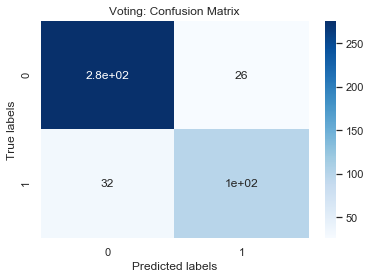

In [80]:
#cm = np.sum(pd.DataFrame(cv_scores)['confusion_matrix'])
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, cmap='Blues', annot=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Voting: Confusion Matrix')

In [39]:
cv_results

,svm,knn,naive bayes,mlp,random forest,gradientboost,logistic,adaboost,stacking,voting
0,0.534091,0.477273,0.579545,0.477273,0.522727,0.386364,0.534091,0.443182,0.850575,0.850575
1,0.863636,0.727273,0.840909,0.693182,0.750000,0.772727,0.875000,0.715909,0.908046,0.816092
2,0.930233,0.883721,0.895349,0.860465,0.848837,0.837209,0.895349,0.918605,0.827586,0.839080
3,0.837209,0.790698,0.860465,0.883721,0.802326,0.837209,0.813953,0.802326,0.908046,0.816092
4,0.953488,0.860465,0.976744,0.988372,0.953488,0.976744,0.930233,0.930233,0.837209,0.860465


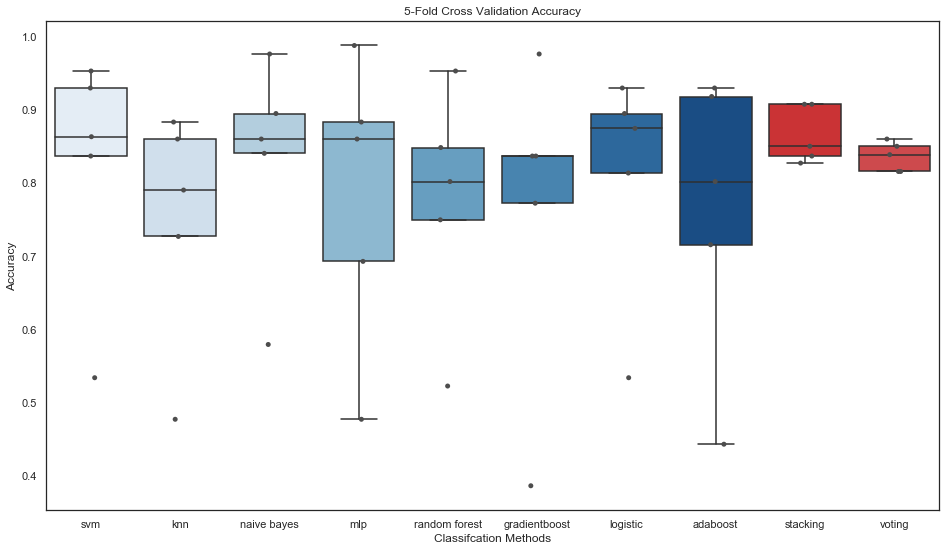

In [77]:
plt.subplots(figsize=(16, 9))
colors = sns.color_palette("Blues", len(base_learners.keys()))
colors.append((0.8901960784313725, 0.10196078431372549, 0.10980392156862745))
colors.append((0.8901960784313725, 0.10196078431372549 * 2, 0.10980392156862745 * 2))
dx = sns.boxplot(data=cv_results, palette=colors, boxprops=dict(alpha=1.0),showfliers = False)
dx = sns.stripplot(data=cv_results,
                   jitter=True,
                   color=".3",
                   dodge=True,
                   marker='o', 
                   alpha=1.0)
dx.set(xlabel='Classifcation Methods',ylabel='Accuracy', title='5-Fold Cross Validation Accuracy')
sns.set(style='white')

In [41]:
score = np.mean(pd.DataFrame(cv_scores)['acc'])
std = 2 * np.std(pd.DataFrame(cv_scores)['acc'])
print('{} ACC Result {} +/- {}'.format('Stacking', score, std))

score = np.mean(pd.DataFrame(cv_scores)['roc_auc_score'])
std = 2 * np.std(pd.DataFrame(cv_scores)['roc_auc_score'])
print('{} ROC-AUC Result {} +/- {}'.format('Stacking', score, std))

Stacking ACC Result 0.8662924351777599 +/- 0.06972955779143106
Stacking ROC-AUC Result 0.8888698129072086 +/- 0.07679570822999876


In [42]:
score = np.mean(pd.DataFrame(cv_scores_vote)['acc'])
std = 2 * np.std(pd.DataFrame(cv_scores_vote)['acc'])
print('{} ACC Result {} +/- {}'.format('Voting', score, std))

score = np.mean(pd.DataFrame(cv_scores_vote)['roc_auc_score'])
std = 2 * np.std(pd.DataFrame(cv_scores_vote)['roc_auc_score'])
print('{} ROC-AUC Result {} +/- {}'.format('Voting', score, std))

Voting ACC Result 0.8364608393477679 +/- 0.03591158164506644
Voting ROC-AUC Result 0.9330083448331938 +/- 0.055637238470835695
